In [62]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
# Info for loading in data
exp_dir = {'aquaplanet': 'tau_sweep/aquaplanet/depth=1/',
           'land': 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'}
kappa_names = ['k=1_2m', 'k=1_5_2m']
kappa_names = ['k=1_2m']
# kappa_names = ['k=3']
n_kappa = len(kappa_names)

region = 'tropics'
hemisphere = 'north'
season = 'summer'
lat_min = 0
lat_max = 20

if hemisphere == 'north':
    lat_min = np.abs(lat_min)
    lat_max = np.abs(lat_max)
else:
    lat_min = -np.abs(lat_max)
    lat_max = -np.abs(lat_min)

season_months = {'summer': {'tropics': {'north': [5, 6, 7, 8, 9, 10],
                                        'south': [11, 12, 1, 2, 3, 4]},
                            'not_tropics': {'north': [6, 7, 8],
                                            'south': [12, 1, 2]}},
                 'winter': {}}
for key in ['tropics', 'not_tropics']:
    season_months['winter'][key] = {'north': season_months['summer'][key]['south'],
                                    'south': season_months['summer'][key]['north']}

# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'cape',
            'ps']  # only keep variables required to compute relative humidity and MSE
use_time_start = 360 * 2

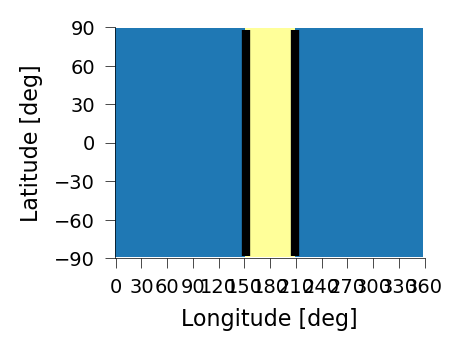

In [4]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir['land'],
                              kappa_names[0].replace('_2m', ''), 'land.nc')

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 2)
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]  # get the longitude coordinates of land

### Convert ds to CESM like data
Below I convert the variable names in the dataset into those expected from CESM.

In [5]:
ds = {key: [] for key in exp_dir}
albedo = {key: [] for key in exp_dir}
tau_sw = {key: [] for key in exp_dir}
tau_lw = {key: [] for key in exp_dir}
with tqdm(total=n_kappa * 2, position=0, leave=True) as pbar:
    for key in exp_dir:
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[key] + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[
                var_keep]
            ds_use['sphum'] = ds_use.sphum.isel(pfull=-1)  # only keep surface SPHUM

            ds_use = ds_use.sel(lat=slice(lat_min, lat_max))
            # Only keep land longitudes - for aquaplanet, does not matter which we keep
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

            # Only load in months of interest for season and hemisphere
            ds_use = isca_tools.utils.annual_time_slice(ds_use, season_months[season][region][hemisphere])
            # Stack longitude and time into new sample dimension to match CESM
            # ds_use = ds_use.stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
            ds[key] += [ds_use.load()]

        namelist = isca_tools.load_namelist(exp_dir[key] + kappa_names[j])  # Need this for albedo_value
        albedo[key] += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw[key] += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw[key] += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        ds[key] = xr.concat(ds[key], dim=xr.DataArray(tau_lw[key], dims="tau_lw",
                                                      name='tau_lw'))

# Concatenate ds along surf dimension
ds = xr.concat([ds[key] for key in ds],
               dim=xr.DataArray([key for key in ds], dims="surf", name='surf'))

# Rename variables to match CESM
ds = ds.rename({'temp': 'T', 'sphum': 'QREFHT',
                'height': 'Z3', 'cape': 'CAPE', 'ps': 'PS',
                'pfull': 'lev'})

# sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
# hybm are sigma full levels
hybm = np.convolve(sigma_levels_half, np.ones(2) / 2,
                   'valid')  # sigma levels corresponding to pressure levels
ds['hybm'] = ds.lev * 0 + hybm  # convert to xarray

# choose lowest model level as REFHT
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.PS * ds.hybm.isel(lev=-1)

  0%|          | 0/2 [00:00<?, ?it/s]

### Compute variables for lapse fitting
Below, I compute the LCL and FT variables required to do the vertical temperature profile fitting.

In [7]:
def get_P(ds):
    return ds.PS * ds.hybm

temp_lcl_bolton_use = float(np.ceil(ds.TREFHT.median()))

ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['rh_REFHT'] = ds.QREFHT / sphum_sat(ds.TREFHT, ds.PREFHT)
ds['p_lcl'] = lcl_sigma_bolton_simple(ds.rh_REFHT, temp_lcl_bolton_use) * ds.PREFHT
# ds['T_lcl_parcel'] =
ds['T_lcl_env'] = get_var_at_plev(ds.T, get_P(ds), ds.p_lcl)
# ds['mse_env'] = get_mse_env(ds.T, ds.P, ds.Z3, ds.p_lcl, sphum_below_lcl=ds.QREFHT)

In [8]:
p_ft = 500 * 100
ds['T_ft_env'] = get_var_at_plev(ds.T, get_P(ds), p_ft)
ds['Z_ft_env'] = get_var_at_plev(ds.Z3, get_P(ds), p_ft)
ds['mse_ft_env_sat'] = moist_static_energy(ds.T_ft_env, sphum_sat(ds.T_ft_env, p_ft), ds.Z_ft_env)

## Analysis as function of temperature quantile, $x$
Next, for a range of `TREFHT` quantiles, I first get the `ds` conditioned on these temperatures.

Then I compute the parameters and error for the `const` and `mod_parcel` lapse rate profiles on these sample days.

In [9]:
def get_ds_quant_single_coord(ds, quant=90, range_below=0.5, range_above=0.5):
    quant_mask = get_quant_ind(ds.TREFHT.squeeze(), quant, range_below, range_above, av_dim=['lon', 'time'], return_mask=True)
    ds_use = ds.where(quant_mask).stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
    ds_use = ds_use.load()
    ds_use = ds_use.where(ds_use.TREFHT>0, drop=True)
    return ds_use

def get_ds_quant(ds, quant=90, range_below=0.5, range_above=0.5, n_keep=None):
    quant_mask = get_quant_ind(ds.TREFHT, quant, range_below, range_above, av_dim=['lon', 'time'], return_mask=True)
    # n_keep is so can concat ds of different quantiles. A given quant range will give slightly different numbers of samples at each location.
    # Through providing n_keep, you can ensure the number is always the same.
    n_keep_max = int(quant_mask.sum(dim=['lon', 'time']).min())
    if n_keep is None:
        n_keep = n_keep_max
    if n_keep > n_keep_max:
        raise ValueError(f'n_keep={n_keep} > n_keep_max={n_keep_max}')
    ds_out = []
    for i in range(ds.tau_lw.size):
        ds_use_j = []
        for j in range(ds.surf.size):
            ds_use_k = []
            for k in range(ds.lat.size):
                ds_use_k.append(get_ds_quant_single_coord(ds.isel(tau_lw=i, surf=j, lat=k, drop=True), quant, range_below, range_above).isel(sample=slice(0, n_keep)))
            ds_use_k = xr.concat(ds_use_k, dim=ds.lat)
            ds_use_j.append(ds_use_k)
        ds_use_j = xr.concat(ds_use_j, dim=ds.surf)
        ds_out.append(ds_use_j)
    ds_out = xr.concat(ds_out, dim=ds.tau_lw)
    return ds_out

In [49]:
quant_range = 0.05
n_sample = 10
quant_all = np.arange(1, 100, 7)
ds_quant = []
for i in tqdm(quant_all):
    ds_quant.append(get_ds_quant(ds, i, quant_range, quant_range, n_sample))
ds_quant = xr.concat(ds_quant, dim=xr.DataArray(quant_all, dims="quant", name='quant'))

  0%|          | 0/15 [00:00<?, ?it/s]

In [50]:
def get_lapse_fitting_info(ds):
    ds.attrs['n_lev_above_integral'] = 3
    var_names = ['lapse', 'integral', 'error']

    with tqdm(total=2, position=0, leave=True) as pbar:
        for key in ['const', 'mod_parcel']:
            var = fitting_2_layer_xr(ds.T, get_P(ds), ds.TREFHT, ds.PREFHT, ds.rh_REFHT, ds.T_ft_env,
                                                     p_ft, n_lev_above_upper2_integral=ds.n_lev_above_integral,
                                                     method_layer2=key)
            # Must include fillna as inf to deal with all nan slice.
            for k, key2 in enumerate(var_names):
                ds[f'{key}1_{key2}'] = var[k]
            pbar.update(1)
    return ds

In [52]:
ds_quant = get_lapse_fitting_info(ds_quant)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
epsilon = ds_quant.mse_REFHT - ds_quant.mse_ft_env_sat

In [75]:
z_diff = g * (ds_quant.Z_ft_env - ds_quant.ZREFHT)
R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(ds_quant.T_ft_env, ds_quant.PREFHT, p_ft)
beta_ft1 = beta_ft1 / 1000
beta_s1 = get_theory_prefactor_terms(ds_quant.TREFHT, ds_quant.PREFHT, p_ft, sphum=ds_quant.QREFHT)[3]/1000
z_diff_theory = R_mod * (ds_quant.TREFHT + ds_quant.T_ft_env)
z_error = (z_diff - z_diff_theory) / 1000       # units of kJ/kg

In [93]:
ds_quant['TREFHT_parcel'] = ds_quant['T_lcl_env'] * (ds_quant.p_lcl / ds_quant.PREFHT) ** (-R * lapse_dry / g)
ds_quant['T_ft_parcel'] = xr.apply_ufunc(get_temp_adiabat, ds_quant['TREFHT_parcel'],
                                         ds_quant.rh_REFHT * sphum_sat(ds_quant['TREFHT_parcel'], ds_quant.PREFHT),
                                         ds_quant.PREFHT,
                                         input_core_dims=[[], [], []], vectorize=True, kwargs={'pressure_ft': p_ft})

In [121]:
mse_mod_ft_parcel = ((c_p + R_mod) * ds_quant['T_ft_parcel'] + L_v * sphum_sat(ds_quant['T_ft_parcel'], p_ft)) / 1000
mse_mod_ft_env = ((c_p + R_mod) * ds_quant['T_ft_env'] + L_v * sphum_sat(ds_quant['T_ft_env'], p_ft)) / 1000
exponent_use = R * (ds_quant['mod_parcel1_lapse'].isel(layer=1)/1000) / g
mse_mod_ft_parcel_approx = mse_mod_ft_env + beta_ft1 * ((ds_quant['p_lcl']/ds_quant.PREFHT)**exponent_use *
                                                        (p_ft/ds_quant.PREFHT)**(-exponent_use)
                                                        - 1) * ds_quant['T_ft_env']
mse_mod_ft_parcel_error = mse_mod_ft_parcel - mse_mod_ft_parcel_approx

In [128]:
mse_mod_REFHT_parcel = ((c_p - R_mod) * ds_quant.TREFHT_parcel + L_v * ds_quant.rh_REFHT * sphum_sat(ds_quant.TREFHT_parcel, ds_quant.PREFHT))/1000
mse_mod_REFHT_env = ((c_p - R_mod) * ds_quant.TREFHT + L_v * ds_quant.QREFHT)/1000
exponent_use = R * (ds_quant['mod_parcel1_lapse'].isel(layer=0)/1000 - lapse_dry) / g
mse_mod_REFHT_parcel_approx = mse_mod_REFHT_env + beta_s1 * ((ds_quant['p_lcl']/ds_quant.PREFHT)**exponent_use - 1) * ds_quant.TREFHT
mse_mod_REFHT_parcel_error = mse_mod_REFHT_parcel - mse_mod_REFHT_parcel_approx

In [148]:
# Sanity check that parcel mod MSE is the same at surface and parcel
print(float(np.abs(mse_mod_REFHT_parcel - mse_mod_ft_parcel).max()))

1.0311396181350574e-10


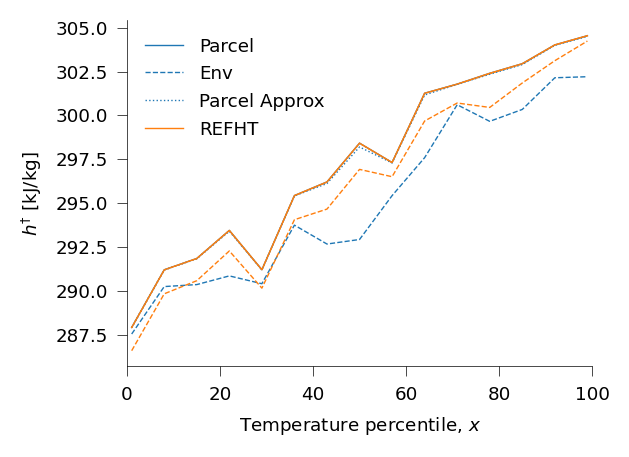

In [144]:
surf_plot = 0
lat_plot = 0
sample_plot = 0
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
ax.plot(ds_quant.quant, mse_mod_ft_parcel.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), label='Parcel', color='C0')
ax.plot(ds_quant.quant, mse_mod_ft_env.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), label='Env', color='C0', linestyle='--')
ax.plot(ds_quant.quant, mse_mod_ft_parcel_approx.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot),
        label='Parcel Approx', color='C0', linestyle=':')

ax.plot(ds_quant.quant, mse_mod_REFHT_parcel.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), label='REFHT', color='C1')
ax.plot(ds_quant.quant, mse_mod_REFHT_env.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), color='C1', linestyle='--')
ax.plot(ds_quant.quant, mse_mod_REFHT_parcel_approx.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot),
        color='C1', linestyle=':')

ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$h^{\dagger}$ [kJ/kg]')
update_fontsize(fig, 7)
ax.set_xlim(0, 100)
plt.show()

# ax.plot(ds_quant.quant, mse_mod_REFHT_parcel.isel(sample=0, surf=0, lat=0))
# plt.plot(ds_quant.quant, mse_mod_ft_env.isel(sample=0, surf=0, lat=0))
# plt.plot(ds_quant.quant, mse_mod_ft_parcel_approx.isel(sample=0, surf=0, lat=0))

In [156]:
epsilon_theory = (mse_mod_ft_parcel_approx - mse_mod_ft_env) - (mse_mod_REFHT_parcel_approx - mse_mod_REFHT_env)
epsilon_error = -z_error + mse_mod_ft_parcel_error - mse_mod_REFHT_parcel_error

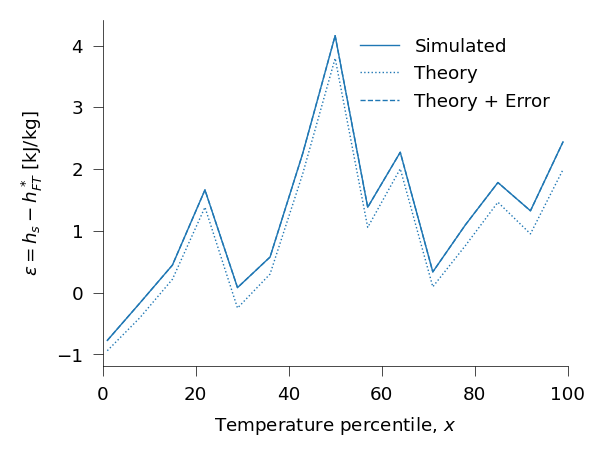

5.2732391450316385e-05


In [165]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
ax.plot(ds_quant.quant, epsilon.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), label='Simulated', color='C0')
ax.plot(ds_quant.quant, epsilon_theory.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), label='Theory', color='C0', linestyle=':')
ax.plot(ds_quant.quant, (epsilon_theory + epsilon_error).isel(surf=surf_plot, lat=lat_plot, sample=sample_plot), label='Theory + Error',
        color='C0', linestyle='--')

ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
update_fontsize(fig, 7)
ax.set_xlim(0, 100)
plt.show()

# Sanity check that theory and error are exact
print(float(np.abs(epsilon - (epsilon_theory + epsilon_error)).max()))